### Importing necessary packages

In [ ]:
# training and testing if made on google colaboratory
from google.colab import drive

drive.mount('/content/drive')

!pip3 install torch torchvision

In [ ]:
# uninstall the older version
!pip uninstall -y Pillow

# install the 5.3.0 version
!pip install Pillow==5.3.0

In [ ]:
# necessary imports
import os
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import cv2

from collections import OrderedDict
from PIL import Image
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset, DataLoader

Device where the training process will be done, either on cpu or gpu if cuda is available.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

### Loading data

In [ ]:
# root path if remote
root_path = '/content/drive/My Drive/flower_classifier/'

In [ ]:
# root path if local
root_path = './'

In [ ]:
data_dir = root_path + 'data'

train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
valid_dir = data_dir + '/valid'

In [ ]:
# simple dataset
simple_image_dataset = datasets.ImageFolder(train_dir, transforms.ToTensor())

def per_sample(sample, mean):
    sample_flatten = sample.view(3, -1)
    
    count = sample_flatten.shape[-1]
    
    for i in range(3):
        sample_flatten[i] = (sample_flatten[i] - mean[i]) ** 2
        
    return sample_flatten.sum(1).numpy(), count

def generate_data_transforms(dataset):
    # calculating mean of images
    images_mean = torch.stack([sample.mean(1).mean(1) for sample, target in dataset])

    # our mean
    trans_mean = images_mean.mean(0)
    
    # pixels count
    count = 0
    
    # pixels sum by channel
    std_sum = np.array([0.0, 0.0, 0.0])
    
    for sample, target in simple_image_dataset:
        sampl = per_sample(sample, trans_mean)

        std_sum += sampl[0]
        count += sampl[1]

    return trans_mean.numpy(), ((std_sum / count) ** (1 / 2))

# data transforms
trans_mean, trans_std = generate_data_transforms(simple_image_dataset)

In [296]:
try:
    if not (network is None):
        trans_mean, trans_std = network.get_transforms_state()
except NameError:
    pass
finally:
    print(trans_mean, trans_std)

[0.43530333 0.37733483 0.28715342] [0.29676435 0.24547096 0.26950462]


In [231]:
# Transforms for training dataset
train_data_transforms = transforms.Compose([
    transforms.ColorJitter(0.15, 0.15, 0.15, 0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.Resize(225),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(trans_mean.tolist(), trans_std.tolist())
])

# Transforms for validation/test dataset
valid_data_transforms = transforms.Compose([
    transforms.Resize(225),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(trans_mean.tolist(), trans_std.tolist())
])

# Batch size
batch_size = 32

# Load the datasets with ImageFolder
image_train_datasets = datasets.ImageFolder(train_dir, transform = train_data_transforms)
image_test_datasets = datasets.ImageFolder(test_dir, transform = valid_data_transforms)
image_valid_datasets = datasets.ImageFolder(valid_dir, transform = valid_data_transforms)

# Using the image datasets and the trainforms, define the dataloaders
train_loader = DataLoader(image_train_datasets, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(image_test_datasets, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(image_valid_datasets, batch_size = batch_size, shuffle = True)

### Label mapping

In [176]:
import json

with open(root_path + 'flower_to_name.json', 'r') as f:
    classes = json.load(f)
    
print("Examples - {:.100}...".format(str(classes)))
print("Number of classes - {}".format(len(classes)))

Examples - {'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': '...
Number of classes - 102


### Displaying images

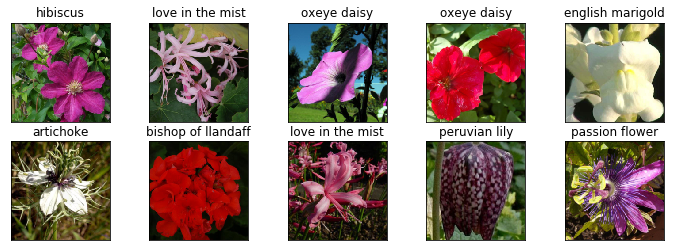

In [295]:
dataset_iter = iter(test_loader)

features, targets = next(dataset_iter)

fig = plt.figure(figsize = (12, 4))

# display 10 images
for index in np.arange(10):
    ax = fig.add_subplot(2, 10 / 2, index + 1, xticks = [], yticks = [])

    outputs = np.transpose(features[index].numpy(), (1, 2, 0)) * trans_std + trans_mean
    
    outputs = np.maximum(np.minimum(outputs, 1.0), 0.0)
    
    ax.imshow(outputs)
    ax.set_title(classes[str(int(targets[index]))])

# Building and training the classifier

Building the classifier.

In [ ]:
class Network:
    def __init__(self, model, model_name, classifier_lay_count, valid_loss_min):
        # our model
        self.model = model
        
        # validation loss minimum
        self.valid_loss_min = valid_loss_min
        
        # model name
        self.model_name = model_name

        # nb of children
        self.children_count = self.calc_children_count(classifier_lay_count)
        
    def set_transforms_state(self, trans_mean, trans_std):
        self.trans_mean = trans_mean
        self.trans_std = trans_std
        
    def get_transforms_state(self):
        return self.trans_mean, self.trans_std

    def calc_children_count(self, classifier_lay_count):
        return sum(1 for x in self.model.parameters()) - classifier_lay_count
        
    def freeze_extractors(self, state = True, whole_network = True, offset = 0):
        if(whole_network):
            start, offset = 0, 0
        else: start, offset = self.children_count, offset
            
        it = 0

        for param in self.model.parameters():
            if(it >= start - offset and it < self.children_count):
                param.requires_grad = not state

            it += 1
            
    def retrieve_params(self, classifierOnly = True):
        if(classifierOnly):
            if(self.model_name == "resnet"):
                return self.model.fc.parameters()
            else: return self.model.classifier.parameters()
        else:
            return self.model.parameters()
                
    
def load_model(model_name, state_dict = None, valid_loss_min = np.inf):
    # loading the model and retrieving the count features
    if(model_name == "resnet"):
        model = models.resnet152(pretrained = True)
        
        features_count = model.fc.in_features
    else: 
        model = models.densenet201(pretrained = True)
        
        features_count = model.classifier.in_features
       
    for param in model.parameters():
        param.requires_grad = False
        
    # custom classifier to be attached to the model 
    classifier = nn.Sequential(
        OrderedDict([
            ('fc1', nn.Linear(features_count, 512)),
            ('rel1', nn.ReLU()),
            ('drpt1', nn.Dropout(p = 0.45)),
            ('fc2', nn.Linear(512, 307)),
            ('rel2', nn.ReLU()),
            ('drpt2', nn.Dropout(p = 0.36)),
            ('fc3', nn.Linear(307, len(classes))),
            ('output', nn.LogSoftmax(dim = 1))
        ])
    )
    
    # replace the classifier
    if(model_name == "resnet"):
        model.fc = classifier
    else: model.classifier = classifier
        
    # loading previous state
    if not (state_dict is None):
        model.load_state_dict(state_dict)

    # move to corresponding available device
    model = model.to(device)
        
    return Network(model, model_name, 8, valid_loss_min)

In [ ]:
# retrieve a model
network = load_model("resnet")

### Defining hyperparameters

In [92]:
def def_hyper_params(lr, classifierOnly = True):
    # learning rate
    learning_rate = lr

    # loss function
    criterion = nn.NLLLoss()

    # optimizer with momentum
    optimizer = optim.Adam(network.retrieve_params(classifierOnly), lr = learning_rate)

    # custom scheduler
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [4, 9], gamma = 0.72)
    
    return learning_rate, criterion, optimizer, scheduler

learning_rate, criterion, optimizer, scheduler = def_hyper_params(0.0004, False)

### Testing the classifier

In [93]:
features, targets = next(iter(train_loader))

# moving features and labels to the corresponding available device
features, targets = features.to(device), targets.to(device)

outputs = network.model.forward(features)

loss = criterion(outputs, targets)

print(loss.item())

0.13865281641483307


### Training the network(feature extractors & classifier)

In [ ]:
def train_model(epochs = 20):
    global learning_rate
    global criterion
    global optimizer
    global scheduler
    
    for epoch in range(epochs):

        # validation constraints
        train_acc_loss, valid_acc_loss = 0, 0

        # training mode
        network.model.train()

        if(epoch == 14):
            network.freeze_extractors(True, True)
 
            learning_rate, criterion, optimizer, scheduler = def_hyper_params(0.09, True)       
            

        scheduler.step(epoch)

        for features, targets in train_loader:

            # removing accumulated gradients
            optimizer.zero_grad()

            # moving features and labels to the corresponding available device
            features, targets = features.to(device), targets.to(device)

            # inference done
            outputs = network.model(features)

            # calculating loss
            loss = criterion(outputs, targets)

            # calculating gradient
            loss.backward()

            # adjusting weights
            optimizer.step()

            train_acc_loss += loss.item() * features.size(0)


        # evaluation mode
        network.model.eval()

        with torch.no_grad():
            for features, targets in test_loader:

                # moving features and labels to the corresponding available device
                features, targets = features.to(device), targets.to(device)

                # inference testing done
                outputs = network.model(features)

                # validation loss
                loss = criterion(outputs, targets)

                # acc validation loss
                valid_acc_loss += loss.item() * features.size(0)

        # average losses calculation
        train_acc_loss = train_acc_loss / len(train_loader.dataset)
        valid_acc_loss = valid_acc_loss / len(test_loader.dataset)

        # print training / validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch + 1, train_acc_loss, valid_acc_loss))

        if(valid_acc_loss <= network.valid_loss_min):
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            network.valid_loss_min,
            valid_acc_loss))

            torch.save(network.model.state_dict(), root_path + 'model_flower_classifier_' + network.model.__class__.__name__ + '.pt')

            network.valid_loss_min = valid_acc_loss
            
# unfreeze some feature extractors  
network.freeze_extractors(False, True)
            
# training model
train_model(26)

In [265]:
def calc_acc(model, data_loader):
    # accuracy
    acc_val = 0

    # eval mode
    model.eval()
                
    with torch.no_grad():
        for features, targets in data_loader:
            # moving features and labels to the corresponding available device
            features, targets = features.to(device), targets.to(device)

            # inference testing done
            outputs = model(features)

            # retrieving top classes
            _, top_class = torch.exp(outputs).topk(1, dim = 1)

            # validation done
            valid_class = top_class.view(*targets.shape) == targets

            acc_val += torch.mean(valid_class.type(torch.FloatTensor))
            
            
    return acc_val / len(data_loader)
            
            
# calculating accuracy
acc_val = calc_acc(network.model, valid_loader)

print(acc_val)

tensor(0.9904)


### Save the checkpoint

In [ ]:
# save the checkpoint
checkpoint = {
    'input_size': [3, 224, 224],
    'batch_size': batch_size,
    'trans_state' : {
        'trans_mean' : trans_mean,
        'trans_std' : trans_std
    },
    'output_size': len(classes),
    'valid_loss_min' : network.valid_loss_min,
    'model_name' : network.model_name,
    'state_dict': torch.load(root_path + 'model_flower_classifier_' + network.model.__class__.__name__ + '.pt')
}

torch.save(checkpoint, root_path + 'model_flower_classifier.pt')

### Loading the checkpoint

In [ ]:
# loading a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    # loading checkpoint
    checkpoint = torch.load(filepath, map_location = 'cpu')
  
    # loading the model
    network = load_model(checkpoint, checkpoint['state_dict'], checkpoint['valid_loss_min'])
    
    # loading the transforms
    network.set_transforms_state(checkpoint['trans_state']['trans_mean'], checkpoint['trans_state']['trans_std'])
    
    return network

network = load_checkpoint(root_path + 'models/model_flower_classifier-0.9904.pt')

## Inference for classification

Tools used for inference of a trained network.


### Image Preprocessing

In [163]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    image.thumbnail((256, 256), Image.ANTIALIAS)
    
    image = image.crop((16, 16, 240, 240))
    image = (np.array(image) / 255 - trans_mean) / trans_std
    
    image = np.transpose(image, (2, 0, 1))
    
    return image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [164]:
def imshow(image, ax = None, title = None):
    """Imshow for Tensor.""" 
    if(ax is None):
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    image = trans_std * image + trans_mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    if(title is not None):
        ax.set_title(title)
    
    ax.grid(False)

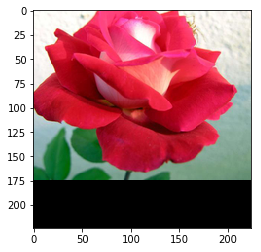

In [214]:
img = Image.open(data_dir + "/train/74/image_01171.jpg")

processed_image = process_image(img)

imshow(processed_image)

### Class Prediction

In [284]:
def predict(image_path, model, topk = 5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    
    model.eval()
    
    outputs = model.forward(image.to(device))
    probabilities = torch.exp(outputs)

    top_prob, top_class = probabilities.topk(topk)
    
    top_prob = top_prob.squeeze(0).detach().cpu().numpy()
    top_class = top_class.squeeze(0).detach().cpu().numpy()
    
    return top_prob, top_class

In [285]:
top_prob, top_class = predict(data_dir + "/test/100/image_07897.jpg", network.model)

print(top_prob)
print(top_class)

[9.9999905e-01 4.4302459e-07 9.6948121e-08 7.1943703e-08 7.0904413e-08]
[ 2 11 12  8 30]


### Sanity Checking

Live prediction with matplotlib.

In [291]:
def view_classify(img_path, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img = Image.open(img_path)

    fig, (ax1, ax2) = plt.subplots(figsize = (12, 4), ncols = 2, nrows = 1)
    flower_name = mapper[img_path.split("/")[-2]]
    
    img = process_image(img)
    imshow(img, ax = ax1, title = flower_name)

    ln = len(classes)
    idx_to_class = { value : key for key, value in image_train_datasets.class_to_idx.items() }

    ax2.barh(np.arange(ln), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(ln))
    ax2.set_yticklabels([
         mapper[idx_to_class[x]] for x in classes 
    ], size = 'small')
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

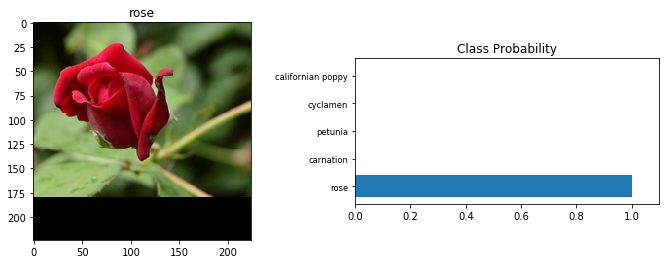

In [294]:
img_path = data_dir + "/test/74/image_01191.jpg"

top_prob, top_class = predict(img_path, network.model)

view_classify(img_path, top_prob, top_class, classes)